# Aplicação de Aprendizagem de Profunda na Detecção de Pneumonia

Disciplina de Introdução a Aprendizagem Profunda (IF867)

Alunos:

*   Ana Carla Guerra (acgam)
*   Lucas Van-Lume Lima (lvll)
*   Maria Carolina Berrafato (mcsb3)

## Importação do dataset
Instalando Kaggle e o Pandas:

In [ ]:
!pip install kaggle
!pip install pandas

In [ ]:
from google.colab import files

Upload do arquivo que contém a chave da API do Kaggle:

In [ ]:
files.upload()

Criação do diretório para a leitura da chave Kaggle:

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Autenticação e download do dataset:

In [ ]:
# Authenticate using your Kaggle API credentials
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Use the 'dataset_download_files' method to download the dataset
api.dataset_download_files('paultimothymooney/chest-xray-pneumonia')

# The dataset will be downloaded as a zip file, you can unzip it
import zipfile
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset-folder')  # Extract to a specific folder

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


Importação de bibliotecas:

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

Separação das pastas de treinamento, test e validação:

In [ ]:
train_dir = "../content/dataset-folder/chest_xray/chest_xray/train/"
test_dir = "../content/dataset-folder/chest_xray/chest_xray/test/"
val_dir = "../content/dataset-folder/chest_xray/chest_xray/val/"

## Visualização dos dados

In [ ]:


print("========================================\nTrain set:")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("========================================\nTest set:")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("========================================\nValidation set:")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
PNEUMONIA=3876
NORMAL=1342
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=9
NORMAL=9


Imagens de raio-X com diagnóstico de pneumonia

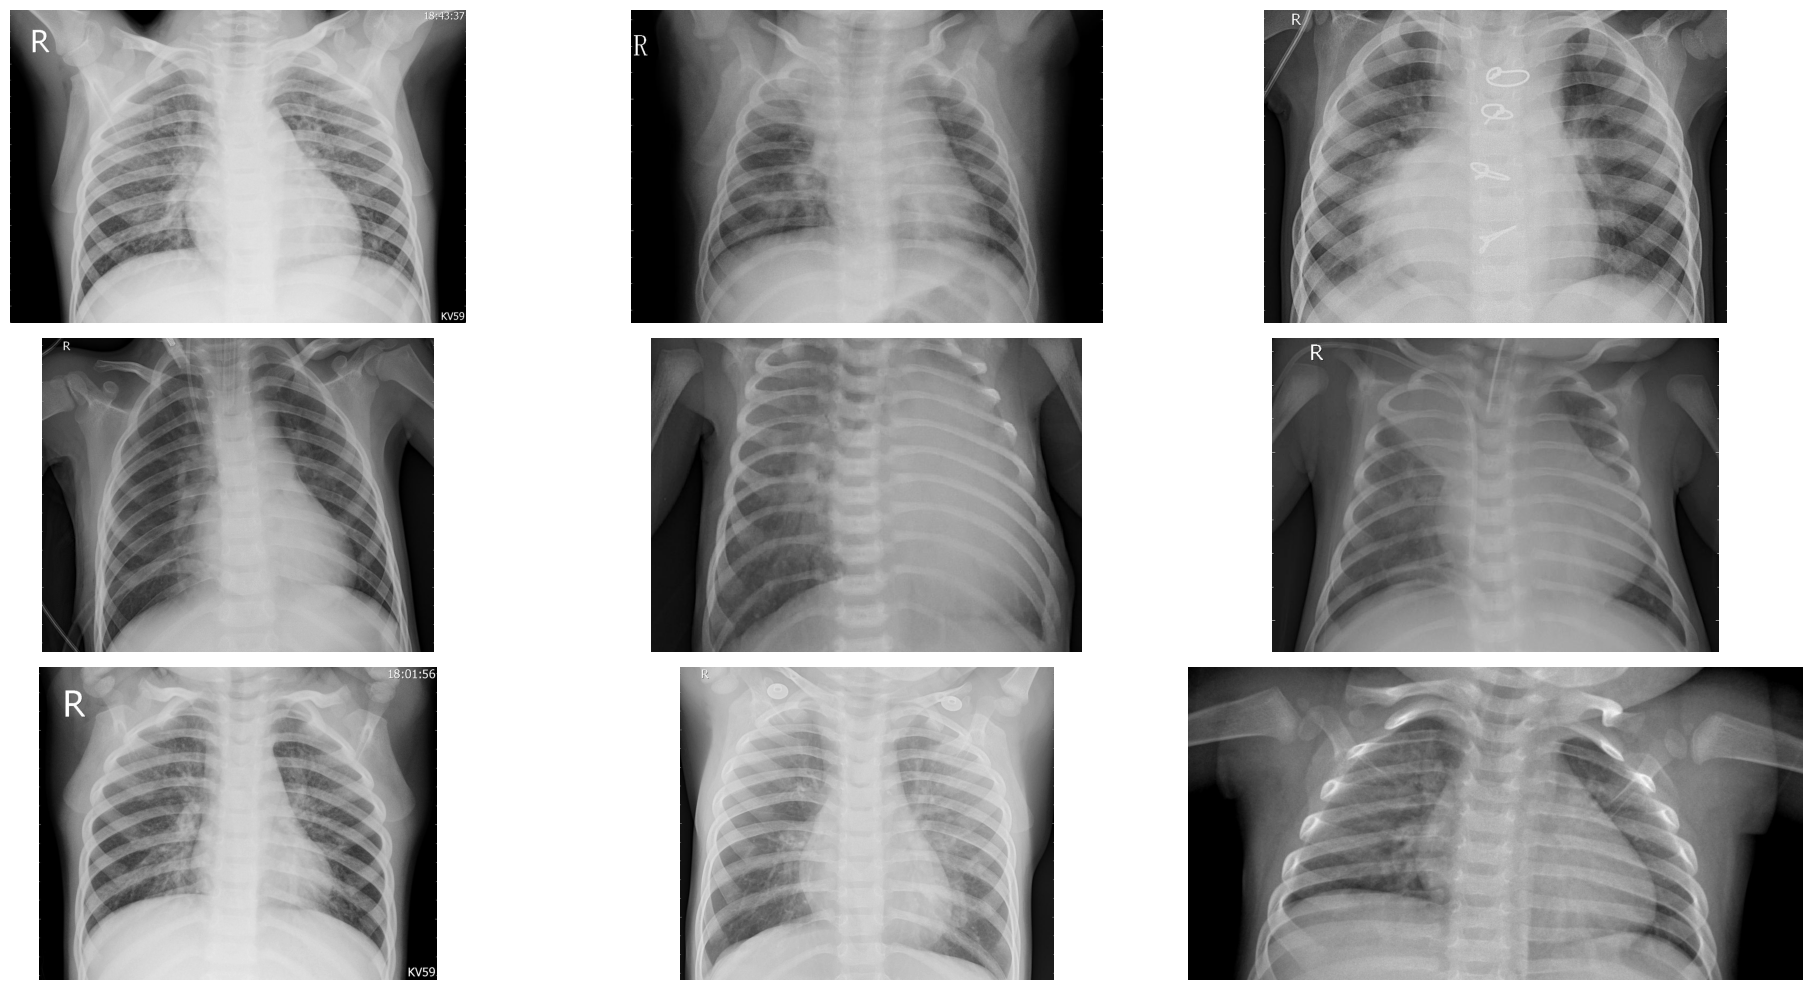

In [ ]:
pneumonia = os.listdir("../content/dataset-folder/chest_xray/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../content/dataset-folder/chest_xray/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

Imagens de raio-X saudáveis

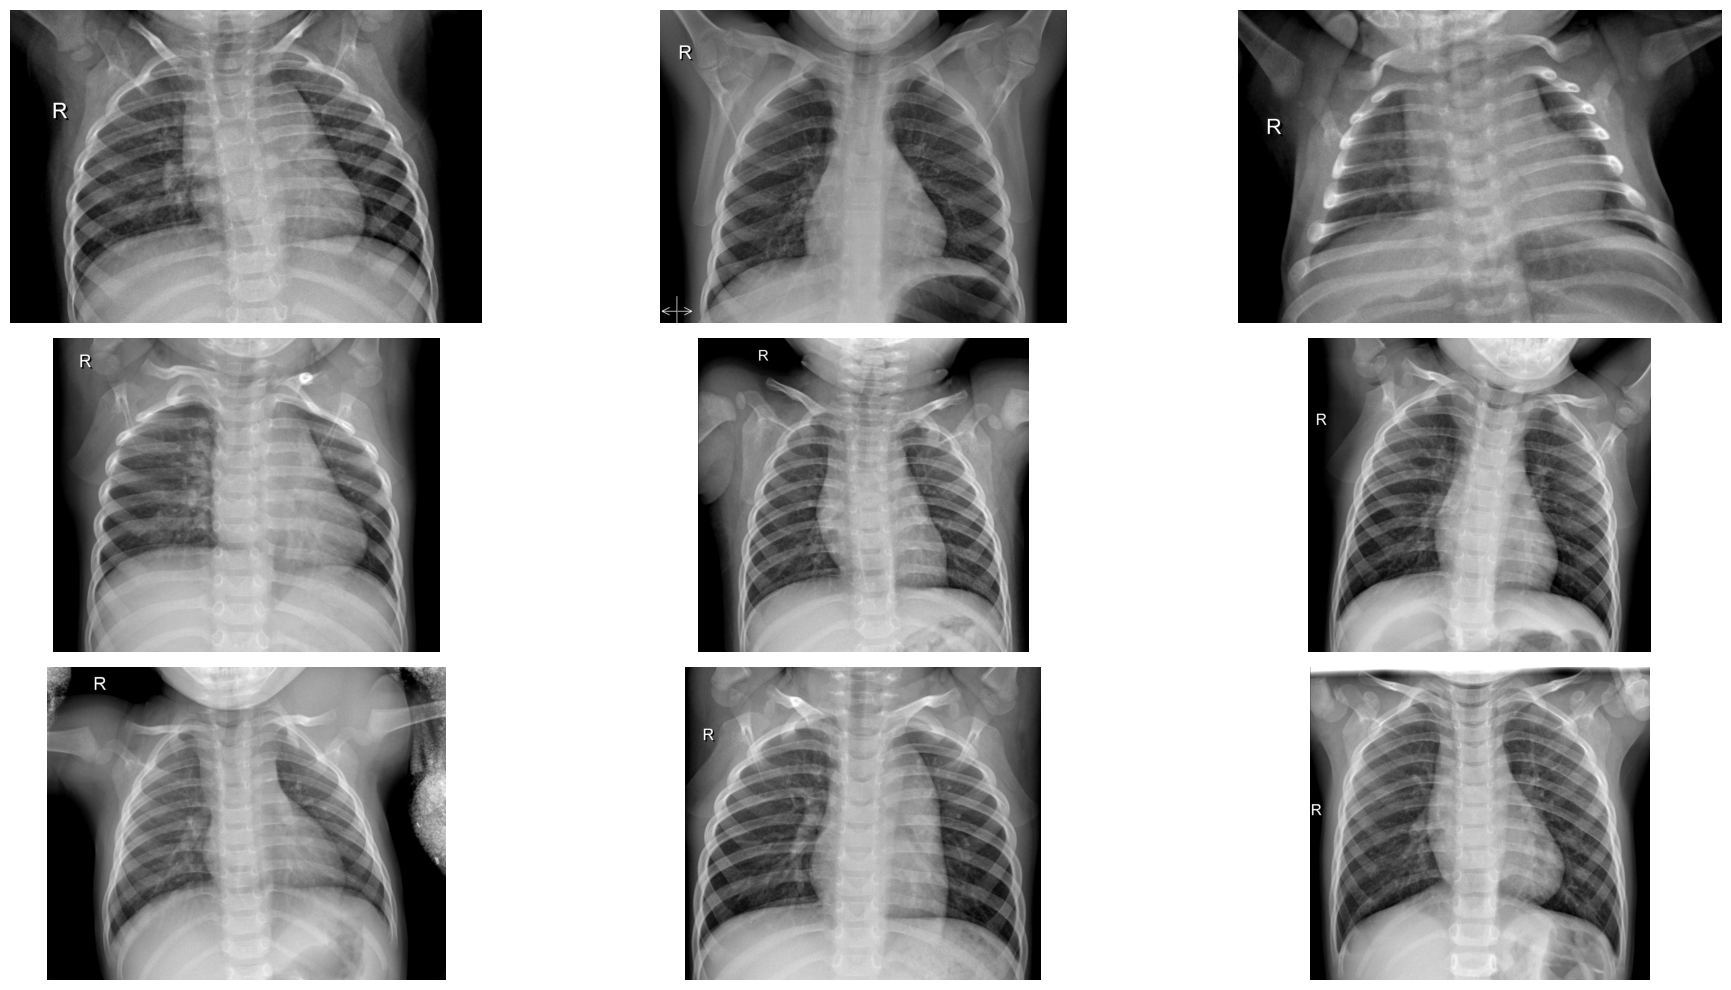

In [ ]:
normal = os.listdir("../content/dataset-folder/chest_xray/chest_xray/train/NORMAL")
normal_dir = "../content/dataset-folder/chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

Informações sobre as imagens

The dimensions of the image are 978 pixels width and 1472 pixels height, one single color channel.

The maximum pixel value is 255.0000 and the minimum is 0.0000.

The mean value of the pixels is 99.3904 and the standard deviation is 61.6974.



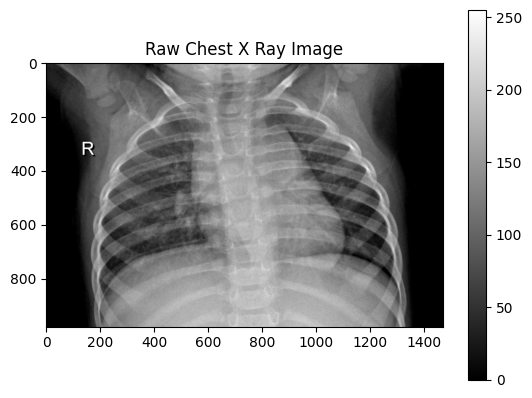

In [ ]:
normal_img = os.listdir("../content/dataset-folder/chest_xray/chest_xray/train/NORMAL")[0]

sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.\n")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}.\n")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}.\n")

Distribuição dos valores dos pixels

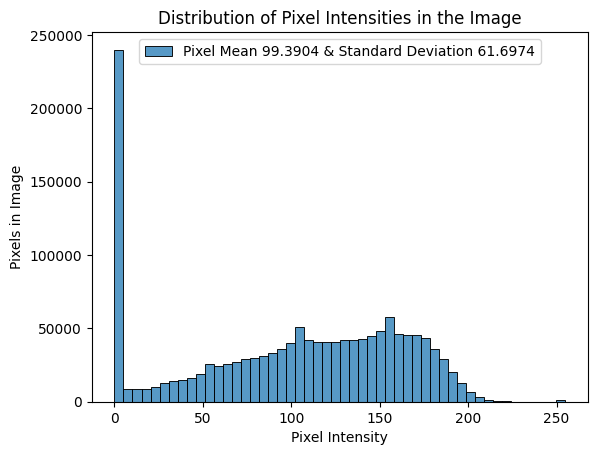

In [ ]:
sns.histplot(sample_img.ravel(), bins=50,
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Pixels in Image')
plt.show()

## Tratamento dos dados

Setando gerador de imagens

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

Gerador de dados para treino, validação e teste

In [ ]:
print("===============\nTrain:")
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180, 180))

print("===============\nValidation:")
validation = image_generator.flow_from_directory(val_dir,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=(180, 180))

print("===============\nTest:")
test = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(180, 180))

Train:
Found 5216 images belonging to 2 classes.
Validation:
Found 16 images belonging to 2 classes.
Test:
Found 624 images belonging to 2 classes.


Informações das imagens tratadas

The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.

The maximum pixel value is 2.7611 and the minimum is -2.6002

The mean value of the pixels is -0.0000 and the standard deviation is 1.0000



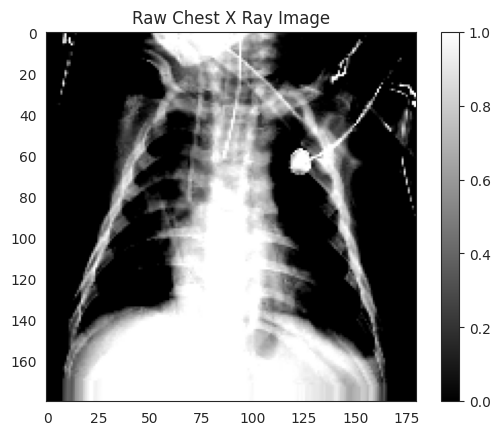

In [ ]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.\n")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}\n")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}\n")

Distribuição dos valores dos pixels das imagens tratadas

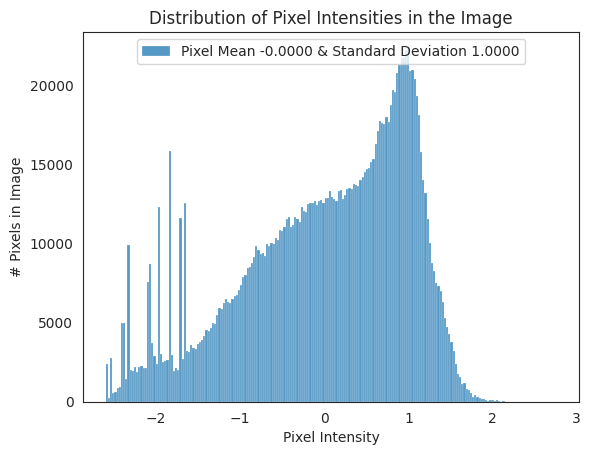

In [ ]:
sns.histplot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

## CNN Model

### Inception V3

In [ ]:
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization

In [ ]:
inception_base_model = InceptionV3(input_shape=(180,180,3),include_top=False,weights='imagenet')

In [ ]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [ ]:
inception_model = tf.keras.Sequential([
    inception_base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.6),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1,activation="sigmoid")
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
inception_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [ ]:
r = inception_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=16)

Epoch 1/10
100/100 [==============================] - 68s 223ms/step - loss: 0.2458 - accuracy: 0.6650 - precision: 0.8876 - recall: 0.6386 - val_loss: 28.7308 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 18s 183ms/step - loss: 0.1804 - accuracy: 0.7775 - precision: 0.9367 - recall: 0.7422 - val_loss: 4.6918 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 17s 172ms/step - loss: 0.1922 - accuracy: 0.7650 - precision: 0.9386 - recall: 0.7359 - val_loss: 0.6783 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 4/10
100/100 [==============================] - 17s 172ms/step - loss: 0.2158 - accuracy: 0.7650 - precision: 0.8855 - recall: 0.7664 - val_loss: 1117.7786 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 17s 171ms/

Text(0.5, 1.0, 'Accuracy Evolution')

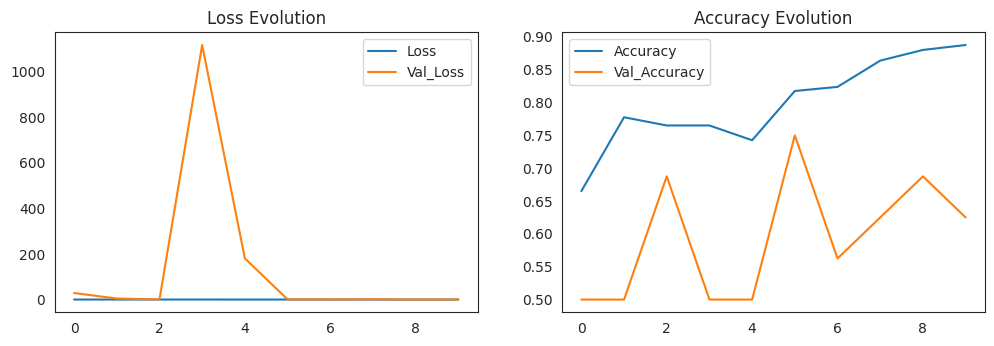

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation =inception_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = inception_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 16s 26ms/step - loss: 0.3727 - accuracy: 0.8349 - precision: 0.9233 - recall: 0.8026
Test Accuracy: 83.49%
652/652 [==============================] - 93s 142ms/step - loss: 0.3549 - accuracy: 0.8156 - precision: 0.9969 - recall: 0.7541
Train Accuracy: 81.56%


<ipython-input-25-9584b6aae862>:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test.samples / test.batch_size)


624/624 [==============================] - 16s 24ms/step


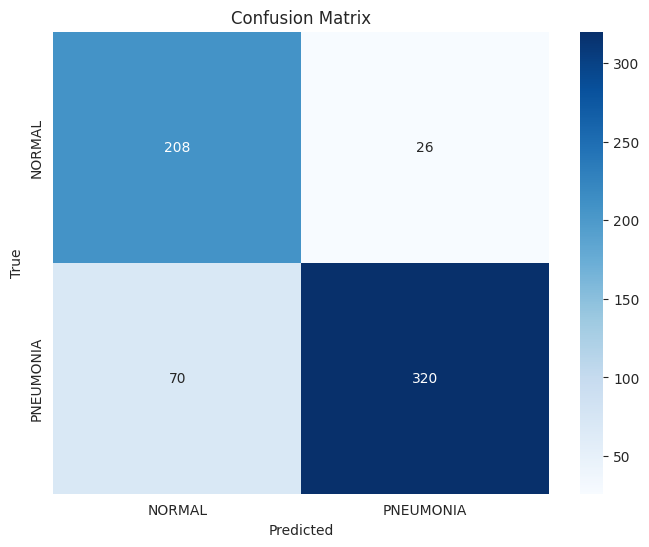

In [ ]:
from sklearn.metrics import confusion_matrix

test_steps_per_epoch = np.math.ceil(test.samples / test.batch_size)
predictions = inception_model.predict(test, steps=test_steps_per_epoch)

predicted_classes = np.where(predictions > 0.5, 1, 0)

true_classes = test.classes

class_labels = list(test.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### VGG16


In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16
# from tensorflow.keras.regularizers import l2

In [ ]:
vgg16_base_model = VGG16(input_shape=(180,180,3),include_top=False,weights='imagenet')

In [ ]:
 vgg16_model = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(1,activation="sigmoid")
    ])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
  'accuracy',
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall')
]
vgg16_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [ ]:
r = vgg16_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=16)

Epoch 1/10
100/100 [==============================] - 24s 168ms/step - loss: 0.3120 - accuracy: 0.6050 - precision: 0.8380 - recall: 0.5678 - val_loss: 20.5296 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 18s 176ms/step - loss: 0.2568 - accuracy: 0.6888 - precision: 0.9062 - recall: 0.6422 - val_loss: 2.9341 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 3/10
100/100 [==============================] - 17s 170ms/step - loss: 0.2341 - accuracy: 0.7113 - precision: 0.9034 - recall: 0.6814 - val_loss: 1.3072 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 4/10
100/100 [==============================] - 17s 165ms/step - loss: 0.2165 - accuracy: 0.7337 - precision: 0.9249 - recall: 0.7077 - val_loss: 1.4667 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/10
100/100 [==============================] - 17s 167ms/step - loss: 0.2101

Text(0.5, 1.0, 'Accuracy Evolution')

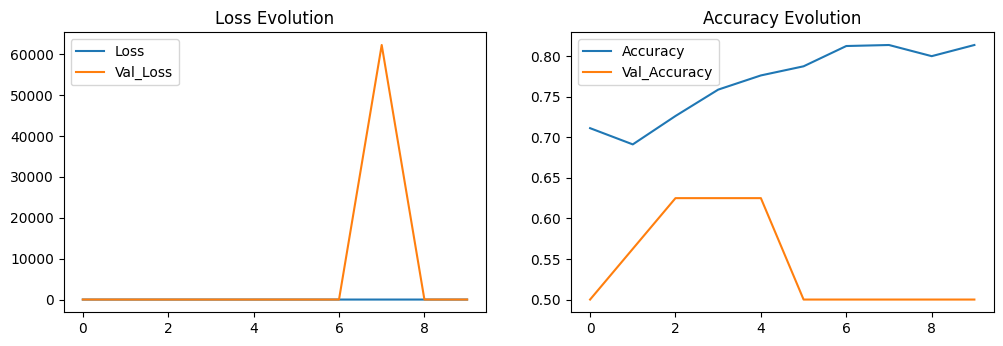

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")



652/652 [==============================] - 104s 160ms/step - loss: 1.1638 - accuracy: 0.7431 - precision: 0.7430 - recall: 1.0000
Train Accuracy: 74.31%
624/624 [==============================] - 13s 21ms/step - loss: 2.0442 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Test Accuracy: 62.50%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

predicted_vals = vgg16_model.predict(test, steps=len(test))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

624/624 [==============================] - 12s 19ms/step


,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.626003,0.626603,0.813002,0.766252
recall,0.004274,1.000000,0.626603,0.502137,0.626603
f1-score,0.008511,0.769990,0.626603,0.389250,0.484435
support,234.000000,390.000000,0.626603,624.000000,624.000000


### Resnet


In [ ]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')

In [ ]:
    resnet_model = tf.keras.Sequential([
        resnet_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=0.001) #
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [ ]:


r = resnet_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=16)

Epoch 1/10
100/100 [==============================] - 50s 175ms/step - loss: 0.3255 - accuracy: 0.5562 - precision: 0.8094 - recall: 0.5236 - val_loss: 2547.0261 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
100/100 [==============================] - 17s 169ms/step - loss: 0.3166 - accuracy: 0.5587 - precision: 0.7916 - recall: 0.5226 - val_loss: 0.7565 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 17s 169ms/step - loss: 0.2747 - accuracy: 0.6162 - precision: 0.8251 - recall: 0.6164 - val_loss: 1.0618 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
100/100 [==============================] - 17s 167ms/step - loss: 0.2221 - accuracy: 0.7163 - precision: 0.8993 - recall: 0.6943 - val_loss: 932.5872 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/10
100/100 [==============================] - 18s 175ms/step - loss: 0.

Text(0.5, 1.0, 'Accuracy Evolution')

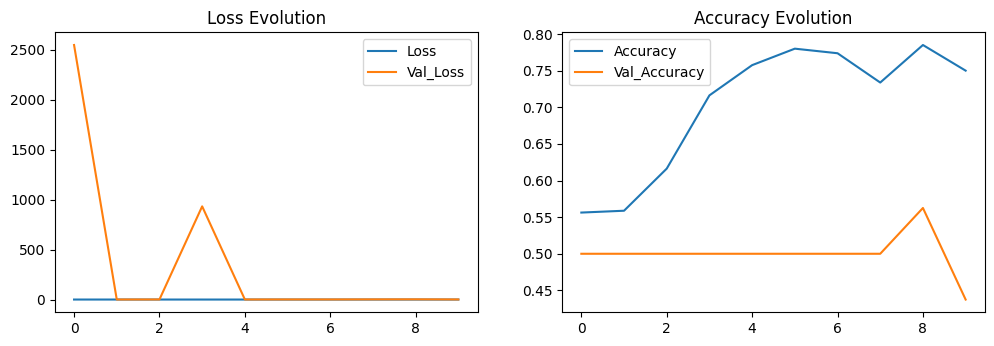

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 14s 22ms/step - loss: 0.8927 - accuracy: 0.6378 - precision: 0.8417 - recall: 0.5179
Test Accuracy: 63.78%
652/652 [==============================] - 92s 141ms/step - loss: 1.1594 - accuracy: 0.5876 - precision: 0.9644 - recall: 0.4619
Train Accuracy: 58.76%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

predicted_vals = resnet_model.predict(test, steps=len(test))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

624/624 [==============================] - 14s 21ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.524675,0.866109,0.655449,0.695392,0.738071
recall,0.863248,0.530769,0.655449,0.697009,0.655449
f1-score,0.652666,0.658188,0.655449,0.655427,0.656117
support,234.000000,390.000000,0.655449,624.000000,624.000000


### DenseNet

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K


In [ ]:
base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [ ]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [ ]:

base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=16,
)

Epoch 1/10
100/100 [==============================] - 89s 227ms/step - loss: 0.1633 - accuracy: 0.8388 - val_loss: 7.4727 - val_accuracy: 0.6250
Epoch 2/10
100/100 [==============================] - 18s 177ms/step - loss: 0.1179 - accuracy: 0.8712 - val_loss: 2.6071 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 19s 186ms/step - loss: 0.0795 - accuracy: 0.9075 - val_loss: 0.7658 - val_accuracy: 0.7500
Epoch 4/10
100/100 [==============================] - 20s 196ms/step - loss: 0.1041 - accuracy: 0.9000 - val_loss: 1.7727 - val_accuracy: 0.5625
Epoch 5/10
100/100 [==============================] - 18s 176ms/step - loss: 0.0872 - accuracy: 0.8925 - val_loss: 0.9195 - val_accuracy: 0.6875
Epoch 6/10
100/100 [==============================] - 20s 195ms/step - loss: 0.0868 - accuracy: 0.9162 - val_loss: 1.2100 - val_accuracy: 0.5625
Epoch 7/10
100/100 [==============================] - 18s 177ms/step - loss: 0.0829 - accuracy: 0.9100 - val_loss: 0.5995 - val_ac

Text(0.5, 1.0, 'Accuracy Evolution')

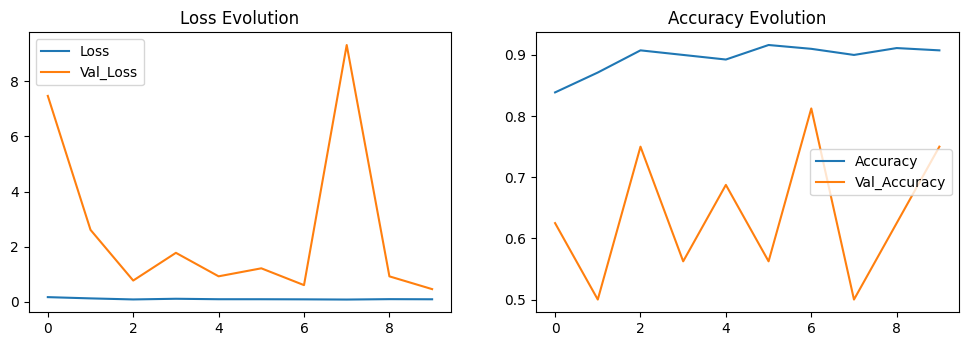

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 15s 24ms/step - loss: 0.2780 - accuracy: 0.8878
Test Accuracy: 88.78%
652/652 [==============================] - 97s 148ms/step - loss: 0.1430 - accuracy: 0.9406
Train Accuracy: 94.06%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

predicted_vals = model.predict(test, steps=len(test))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

624/624 [==============================] - 18s 25ms/step


,0,1,accuracy,macro avg,weighted avg
precision,0.919192,0.877934,0.891026,0.898563,0.893406
recall,0.777778,0.958974,0.891026,0.868376,0.891026
f1-score,0.842593,0.916667,0.891026,0.879630,0.888889
support,234.000000,390.000000,0.891026,624.000000,624.000000


  3/624 [..............................] - ETA: 17s

<ipython-input-39-375e61f9bcb6>:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test.samples / test.batch_size)


624/624 [==============================] - 15s 24ms/step


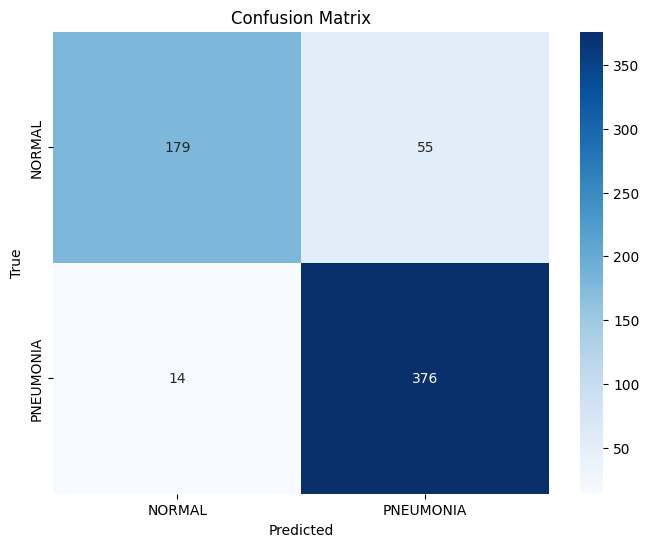

In [ ]:
from sklearn.metrics import confusion_matrix

test_steps_per_epoch = np.math.ceil(test.samples / test.batch_size)
predictions = model.predict(test, steps=test_steps_per_epoch)

predicted_classes = np.where(predictions > 0.5, 1, 0)

true_classes = test.classes

class_labels = list(test.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()